### import

In [44]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score


In [45]:
dataframe = pd.read_csv('../data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [46]:
print("size before deleting outliners", dataframe.shape)

limit_clv = dataframe['Customer Lifetime Value'].quantile(0.95)

dataframe = dataframe[dataframe['Customer Lifetime Value'] < limit_clv]



size before deleting outliners (9134, 24)


In [47]:
x = dataframe.drop(columns=['Customer Lifetime Value','Customer','Effective To Date'])
y = dataframe['Customer Lifetime Value']


In [48]:
categorical_features = x.select_dtypes(include=['object','string']).columns.tolist()
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first'), categorical_features),
    ],remainder='passthrough'
)

x = ct.fit_transform(x)



In [49]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [50]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [51]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


In [52]:
print("R2 score: " , r2_score(y_test, y_pred))


R2 score:  0.829534586861466


###### we will try to go higher


In [53]:
importances = regressor.feature_importances_

feature_names = ct.get_feature_names_out()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance_df.sort_values(by='importance', ascending=False)

print(feature_importance_df.head(10))


                                   feature  importance
0                encoder__State_California    0.002339
1                    encoder__State_Nevada    0.001811
2                    encoder__State_Oregon    0.001882
3                encoder__State_Washington    0.001858
4                    encoder__Response_Yes    0.003162
5               encoder__Coverage_Extended    0.001630
6                encoder__Coverage_Premium    0.000262
7               encoder__Education_College    0.002073
8                encoder__Education_Doctor    0.000353
9  encoder__Education_High School or Below    0.003461


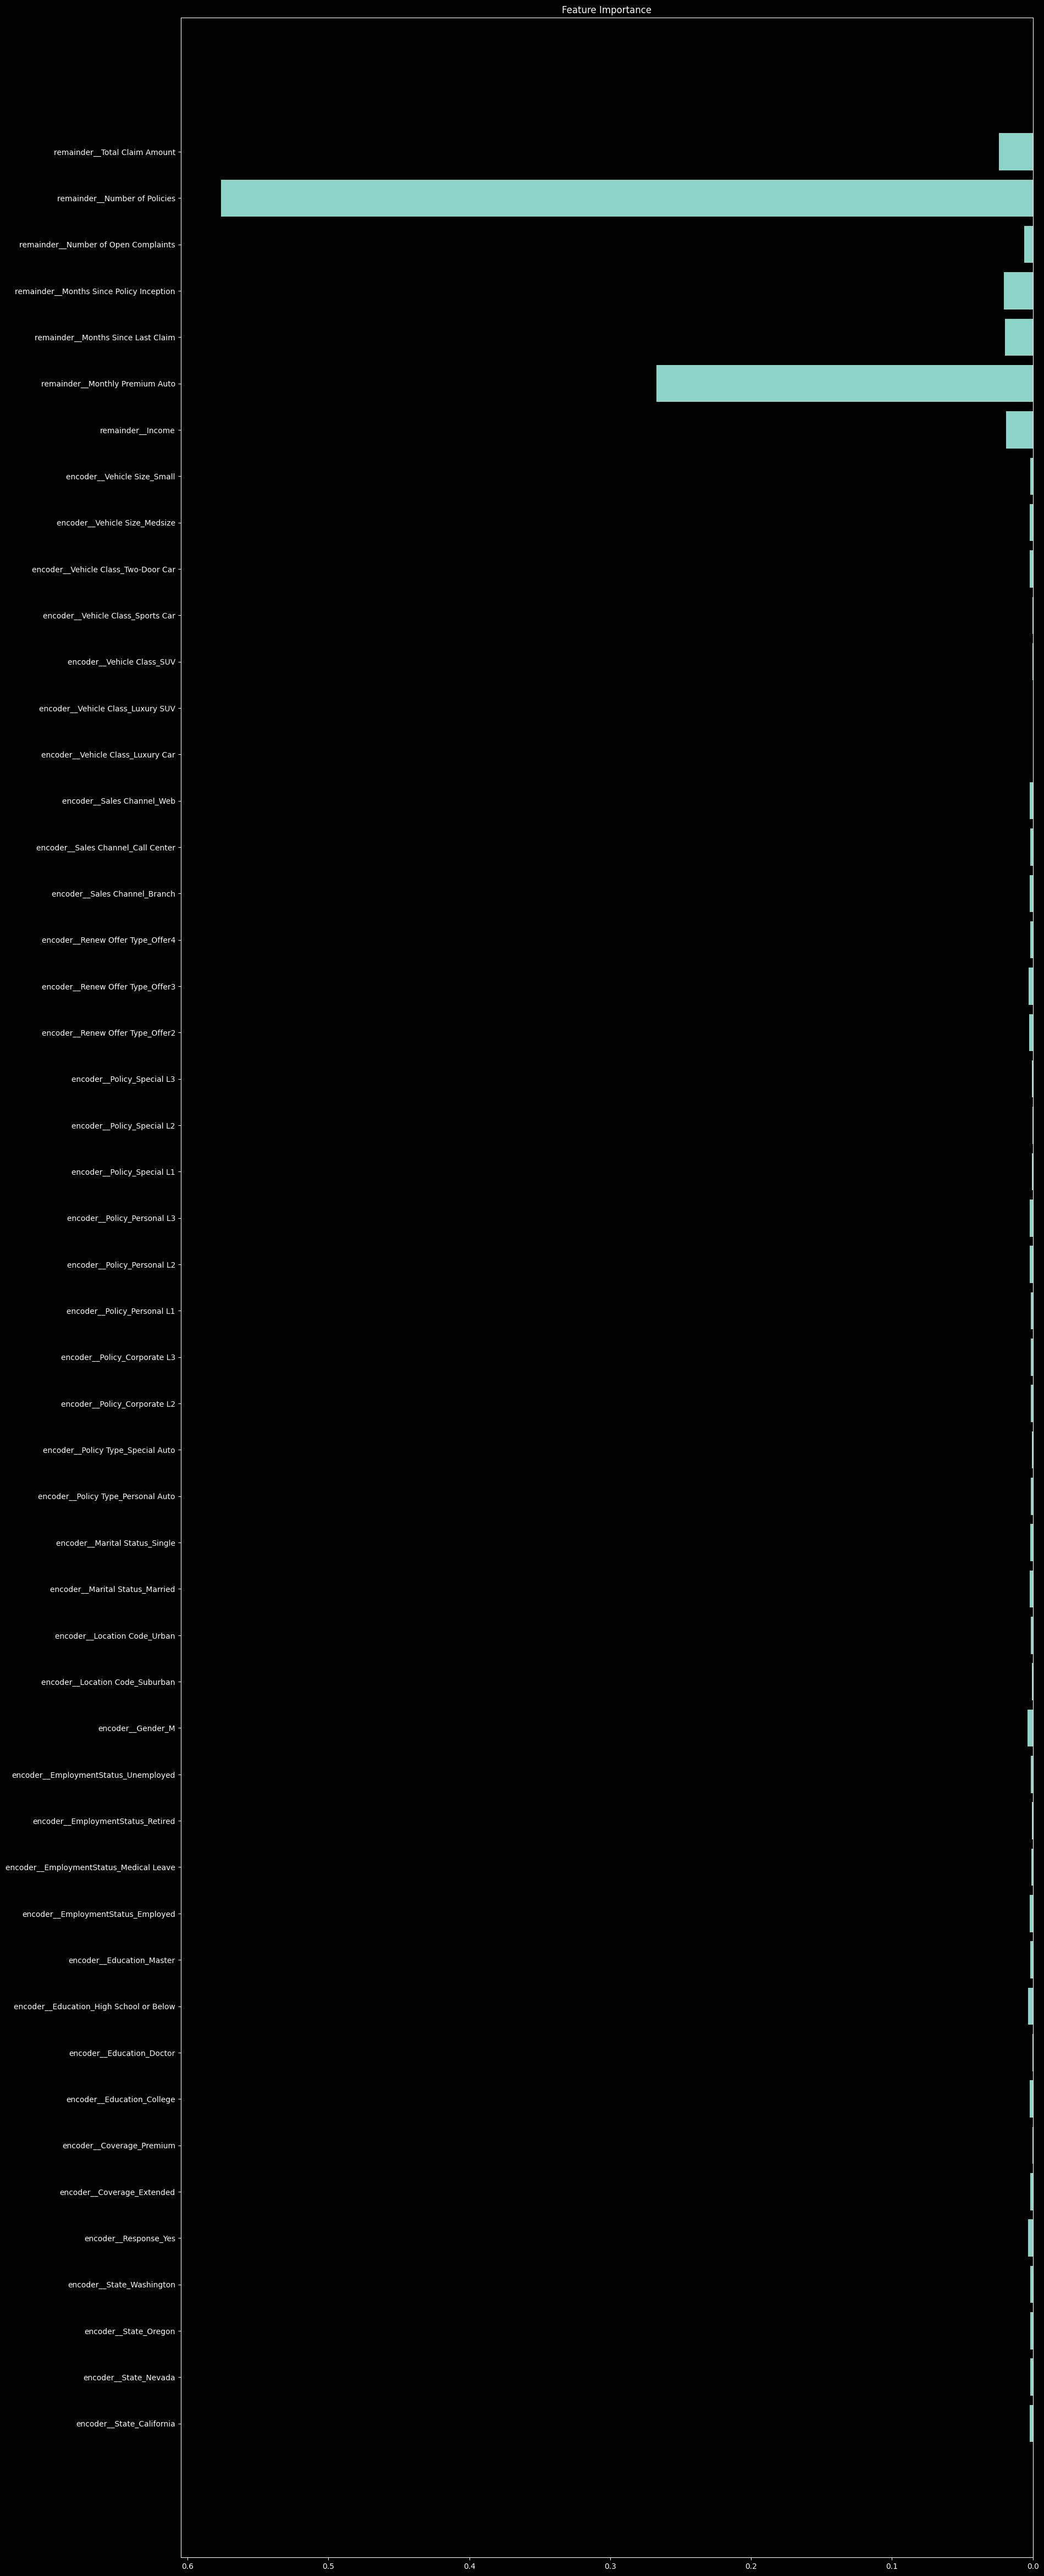

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,60))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_xaxis()
plt.title('Feature Importance')
plt.show()

###### We will try to flatten features by logarithm

In [55]:
y_train_log = np.log(y_train)

regressor_log = RandomForestRegressor(n_estimators=100, random_state=0)
regressor_log.fit(X_train, y_train_log)

y_pred_log = regressor_log.predict(X_test)
y_pred = np.exp(y_pred_log)

print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.8348520097485045


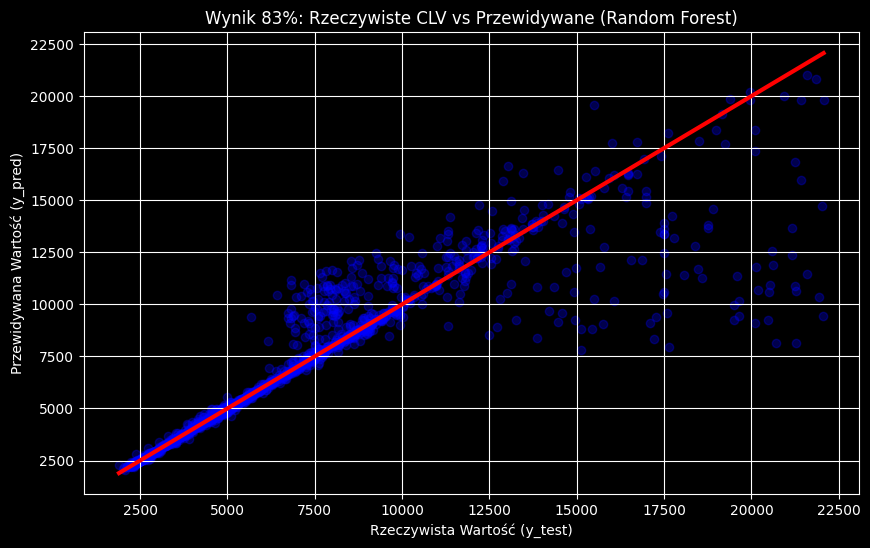

In [56]:
import matplotlib.pyplot as plt

# Generujemy wykres
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')

# Idealna linia (gdyby model był w 100% idealny)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3)

plt.title('Wynik 83%: Rzeczywiste CLV vs Przewidywane (Random Forest)')
plt.xlabel('Rzeczywista Wartość (y_test)')
plt.ylabel('Przewidywana Wartość (y_pred)')
plt.grid(True)
plt.show()

In [57]:
import joblib

artifacts = {
    "model":regressor_log,
    "encoder": ct,
    "scaler": sc,
}

joblib.dump(artifacts, '../models/RandomForestRegressor.joblib')


['models/RandomForestRegressor.joblib']